# Extended Random Forest Classifier

This notebook builds and evaluates a extended Random Forest classifier for soccer match prediction: Over/Under 2.5 goals (binary classification).

## Structure:
- **#0**: Setup and Data Loading
- **#1**: Extended Model Training
- **#2**: Hyperparameter Tuning
- **#3**: Feature Importance Analysis & Model Retraining
- **#4**: Final Evaluation on Test Set

## #0: Setup and Data Loading

### #0.1: Import Required Libraries
Import all necessary libraries for model training, evaluation, and visualization.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, log_loss, confusion_matrix, classification_report)
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import optuna
from optuna.samplers import TPESampler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

### #0.2: Load Preprocessed Data
Load the extended preprocessed data containing training, validation, and test sets.

In [2]:
with open('./outputs/processed/extended_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [3]:
# Check data shapes
print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")
print(f"\nClass distribution in training set:")
class_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
class_names = {0: 'Under 2.5 goals', 1: 'Over 2.5 goals'}
for idx, val in class_dist.items():
    print(f"{class_names[idx]}: {val:.4f}")

Training set: X=(28217, 703), y=(28217,)
Validation set: X=(7247, 703), y=(7247,)
Test set: X=(7129, 703), y=(7129,)

Class distribution in training set:
Under 2.5 goals: 0.5100
Over 2.5 goals: 0.4900


## #1: Extended Model Training

### #1.1: Train Extended Random Forest
Train an untuned Random Forest classifier with default parameters on the training set.

In [4]:
# Train extended Random Forest with default parameters
extended_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training extended Random Forest...")
extended_rf.fit(X_train.copy(), y_train.copy())
print("Training completed!")

Training extended Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.6s


Training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


### #1.2: Evaluate Extended Model on Validation Set
Generate predictions and calculate performance metrics on the validation set.

In [5]:
def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evaluate model and return comprehensive metrics.
    """
    # Predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)

    # Convert to numpy arrays to ensure compatibility
    y = np.array(y)
    y_pred = np.array(y_pred)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)

    # ROC-AUC for binary classification
    try:
        roc_auc = roc_auc_score(y, y_pred_proba[:, 1])
    except:
        roc_auc = None

    # Log Loss (cross-entropy) - lower is better
    try:
        logloss = log_loss(y, y_pred_proba)
    except:
        logloss = None

    print(f"\n{'='*60}")
    print(f"Performance Metrics - {dataset_name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    if logloss is not None:
        print(f"Log Loss:  {logloss:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['Under 2.5', 'Over 2.5'], zero_division=0))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'log_loss': logloss,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [6]:
# Evaluate on validation set
extended_val_results = evaluate_model(extended_rf, X_val, y_val, "Extended - Validation Set")


Performance Metrics - Extended - Validation Set
Accuracy:  0.5824
Precision: 0.5820
Recall:    0.5824
F1-Score:  0.5822
ROC-AUC:   0.6111
Log Loss:  0.6726

Confusion Matrix:
[[1854 1542]
 [1484 2367]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.56      0.55      0.55      3396
    Over 2.5       0.61      0.61      0.61      3851

    accuracy                           0.58      7247
   macro avg       0.58      0.58      0.58      7247
weighted avg       0.58      0.58      0.58      7247



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


### #1.3: Visualize Confusion Matrix
Create a heatmap visualization of the confusion matrix for the validation set.

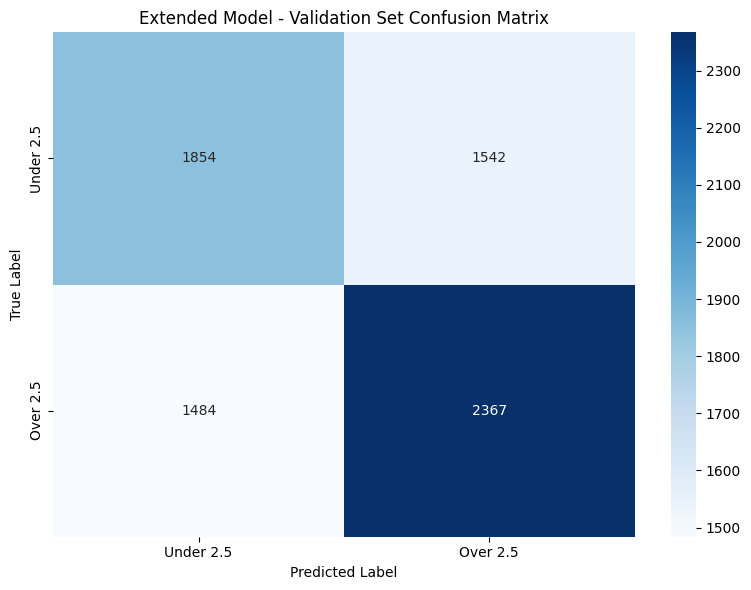

In [7]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plot confusion matrix as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Under 2.5', 'Over 2.5'],
                yticklabels=['Under 2.5', 'Over 2.5'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(extended_val_results['confusion_matrix'],
                     "Extended Model - Validation Set Confusion Matrix")

## #2: Hyperparameter Tuning

### #2.1: Bayesian Optimization with Optuna
Use Optuna to perform Bayesian optimization to find optimal hyperparameters.

In [8]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Uses validation set to evaluate performance.
    Returns: Log Loss to minimize (penalizes confident incorrect predictions)
    """
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    # Create model with suggested hyperparameters
    model = RandomForestClassifier(**params)

    # Train on training set and evaluate on validation set
    model.fit(X_train.copy(), y_train.copy())
    y_val_pred_proba = model.predict_proba(X_val)
    val_logloss = log_loss(np.array(y_val), y_val_pred_proba)

    return val_logloss

# Create study and optimize
print("Starting Bayesian Optimization with Optuna...")
print("Using validation set for hyperparameter evaluation...")
print("Optimizing Log Loss (lower is better, penalizes confident incorrect predictions)...")
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    study_name='random_forest_optuna'
)

# Record start time
start_time = time.time()

study.optimize(objective, n_trials=150, show_progress_bar=True)

# Calculate optimization time
optimization_time = time.time() - start_time

print(f"\nOptimization completed in {optimization_time:.1f} seconds")
print(f"Best Validation Log Loss: {study.best_value:.6f}")
print(f"Best trial: #{study.best_trial.number}")
print(f"\nBest hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

[I 2025-11-16 17:24:36,103] A new study created in memory with name: random_forest_optuna


Starting Bayesian Optimization with Optuna...
Using validation set for hyperparameter evaluation...
Optimizing Log Loss (lower is better, penalizes confident incorrect predictions)...


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-16 17:24:45,272] Trial 0 finished with value: 0.6740754693753548 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6740754693753548.
[I 2025-11-16 17:24:52,275] Trial 1 finished with value: 0.6731637465393127 and parameters: {'n_estimators': 383, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.6731637465393127.
[I 2025-11-16 17:24:52,275] Trial 1 finished with value: 0.6731637465393127 and parameters: {'n_estimators': 383, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.6731637465393127.
[I 2025-11-16 17:26:46,098] Trial 2 finished with value: 0.6725241450157483 and parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_fea

### #2.2: Manual Bayesian Optimization with Gaussian Processes
Implement Bayesian optimization from scratch using Gaussian Processes as surrogate model and UCB acquisition function.

In [9]:
# --------------------------------------------
#  Define objective function for manual BO
# --------------------------------------------
def evaluate_rf_manual(params):
    """
    Evaluate Random Forest with given hyperparameters using validation set.
    Returns: Log Loss to minimize (penalizes confident incorrect predictions)
    """
    # Handle max_features categorical parameter (encoded as continuous for GP)
    max_features_map = {0: 'sqrt', 1: 'log2', 2: None}
    max_features_idx = int(round(params[4]))
    max_features_idx = np.clip(max_features_idx, 0, 2)  # Ensure valid range
    max_features_val = max_features_map[max_features_idx]

    # Handle bootstrap boolean (encoded as continuous for GP)
    bootstrap_val = bool(params[5] > 0.5)

    model = RandomForestClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        min_samples_split=int(params[2]),
        min_samples_leaf=int(params[3]),
        max_features=max_features_val,
        bootstrap=bootstrap_val,
        random_state=42,
        n_jobs=-1
    )

    # Train on training set and evaluate on validation set
    model.fit(X_train.copy(), y_train.copy())
    y_val_pred_proba = model.predict_proba(X_val)
    val_logloss = log_loss(np.array(y_val), y_val_pred_proba)

    # Return log loss (already a minimization metric)
    return val_logloss

# --------------------------------------------
#  Define search space bounds
# --------------------------------------------
param_bounds = np.array([
    [100, 500],      # n_estimators: 100-500
    [5, 30],         # max_depth: 5-30
    [2, 20],         # min_samples_split: 2-20
    [1, 10],         # min_samples_leaf: 1-10
    [0, 2],          # max_features: 0='sqrt', 1='log2', 2=None
    [0, 1],          # bootstrap: 0=False, 1=True (continuous for GP)
])

n_params = param_bounds.shape[0]

# --------------------------------------------
#  Initialize samples (random warm-up phase)
# --------------------------------------------
np.random.seed(42)
N_INIT = 20  # Initial random samples to warm up the GP

print("🔧 Initializing Manual Bayesian Optimization...")
print(f"Generating {N_INIT} random initial samples...")

X_samples = np.random.uniform(param_bounds[:, 0], param_bounds[:, 1], size=(N_INIT, n_params))
Y_samples = np.array([evaluate_rf_manual(x) for x in X_samples])

print(f"Initial samples generated. Best initial Validation Log Loss: {np.min(Y_samples):.6f}")

# --------------------------------------------
#  Fit Gaussian Process surrogate model
# --------------------------------------------
kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=3,
    random_state=42
)

# Normalize features for better GP performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_samples)
gp.fit(X_scaled, Y_samples)

# --------------------------------------------
#  Acquisition function (Upper Confidence Bound)
# --------------------------------------------
def acquisition_ucb(X, model, kappa=2.0):   
    """
    Upper Confidence Bound acquisition function.
    Since we're minimizing Log Loss, we use LCB (Lower Confidence Bound).

    LCB = mu - kappa * sigma (for minimization)
    """
    mu, sigma = model.predict(X, return_std=True)
    return mu - kappa * sigma  # Lower is better for minimization

def propose_next(model, bounds, scaler, n_candidates=2000):
    """Propose next point to evaluate using acquisition function"""
    candidates = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_candidates, bounds.shape[0]))
    candidates_scaled = scaler.transform(candidates)
    acq_vals = acquisition_ucb(candidates_scaled, model)
    best_idx = np.argmin(acq_vals)
    return candidates[best_idx].reshape(1, -1)

# --------------------------------------------
#  Bayesian Optimization loop
# --------------------------------------------
N_ITER = 130  # Number of BO iterations (150 total evaluations = 20 init + 130 iterations)
history_best = [np.min(Y_samples)]

print(f"\nStarting Bayesian Optimization loop with {N_ITER} iterations...")
start_time = time.time()

for i in range(N_ITER):
    # Propose next point using acquisition function
    x_next = propose_next(gp, param_bounds, scaler)
    y_next = evaluate_rf_manual(x_next[0])

    # Update dataset
    X_samples = np.vstack([X_samples, x_next])
    Y_samples = np.hstack([Y_samples, y_next])

    # Refit Gaussian Process
    X_scaled = scaler.fit_transform(X_samples)
    gp.fit(X_scaled, Y_samples)

    # Track progress
    history_best.append(np.min(Y_samples))
    current_best_logloss = np.min(Y_samples)
    current_logloss = y_next

    # Print every iteration to see progress
    if (i + 1) % 5 == 0 or i < 5:
        print(f"Iteration {i+1:02d}/{N_ITER}: Current Val Log Loss = {current_logloss:.6f}, Best Val Log Loss = {current_best_logloss:.6f}")

optimization_time = time.time() - start_time

# --------------------------------------------
#  Extract best parameters
# --------------------------------------------
best_idx = np.argmin(Y_samples)
best_params_array = X_samples[best_idx]
best_logloss_manual = Y_samples[best_idx]

# Convert to dictionary format
max_features_map = {0: 'sqrt', 1: 'log2', 2: None}
manual_bo_params = {
    'n_estimators': int(best_params_array[0]),
    'max_depth': int(best_params_array[1]),
    'min_samples_split': int(best_params_array[2]),
    'min_samples_leaf': int(best_params_array[3]),
    'max_features': max_features_map[int(round(np.clip(best_params_array[4], 0, 2)))],
    'bootstrap': bool(best_params_array[5] > 0.5),
}

print(f"\nManual Bayesian Optimization completed in {optimization_time:.1f} seconds")
print(f"Best Validation Log Loss: {best_logloss_manual:.6f}")
print(f"Total evaluations: {len(Y_samples)}")
print(f"\nBest hyperparameters found:")
for name, val in manual_bo_params.items():
    print(f"  {name}: {val}")

🔧 Initializing Manual Bayesian Optimization...
Generating 20 random initial samples...
Initial samples generated. Best initial Validation Log Loss: 0.670183

Starting Bayesian Optimization loop with 130 iterations...
Initial samples generated. Best initial Validation Log Loss: 0.670183

Starting Bayesian Optimization loop with 130 iterations...
Iteration 01/130: Current Val Log Loss = 0.675000, Best Val Log Loss = 0.670183
Iteration 01/130: Current Val Log Loss = 0.675000, Best Val Log Loss = 0.670183
Iteration 02/130: Current Val Log Loss = 0.670817, Best Val Log Loss = 0.670183
Iteration 02/130: Current Val Log Loss = 0.670817, Best Val Log Loss = 0.670183
Iteration 03/130: Current Val Log Loss = 0.677305, Best Val Log Loss = 0.670183
Iteration 03/130: Current Val Log Loss = 0.677305, Best Val Log Loss = 0.670183
Iteration 04/130: Current Val Log Loss = 0.674757, Best Val Log Loss = 0.670183
Iteration 04/130: Current Val Log Loss = 0.674757, Best Val Log Loss = 0.670183
Iteration 05/

### #2.3: Compare Optimization Methods
Compare the performance of Optuna vs Manual Bayesian Optimization.


HYPERPARAMETER OPTIMIZATION COMPARISON

🔹 Optuna Optimization:
   Best Validation Log Loss: 0.669689
   Total evaluations: 150

🔹 Manual Bayesian Optimization:
   Best Validation Log Loss: 0.669983
   Total evaluations: 150

🔹 Difference:
   Optuna is better by 0.000294 (lower is better)


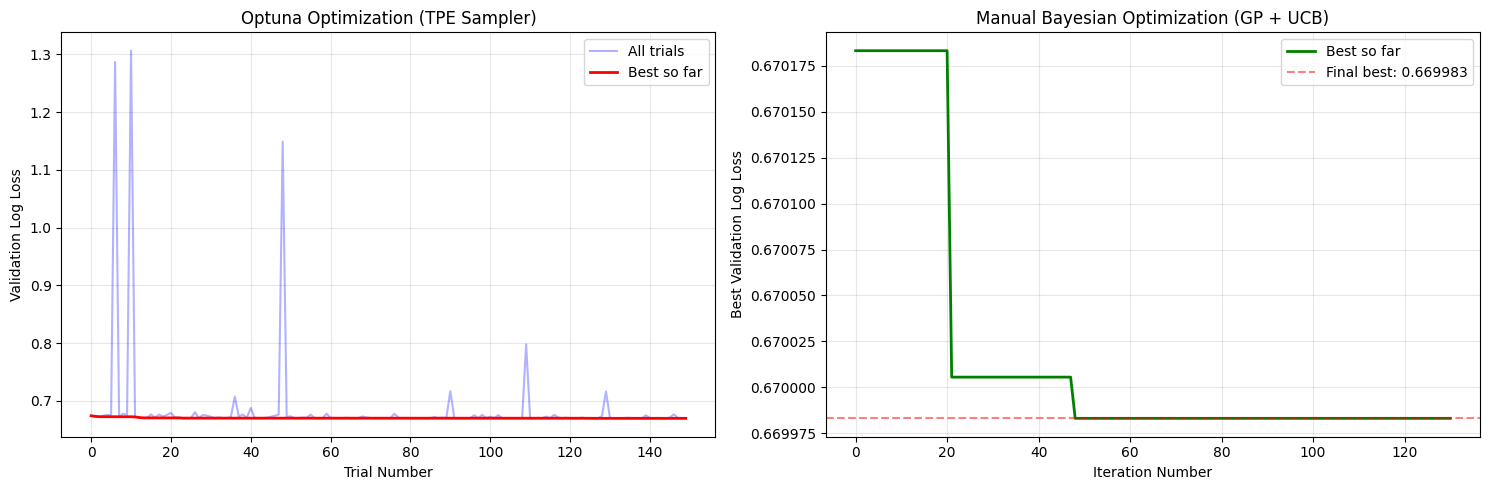


📊 Best Hyperparameters Comparison:
Parameter            Optuna               Manual BO           
------------------------------------------------------------
n_estimators         119                  307                 
max_depth            7                    5                   
min_samples_split    4                    6                   
min_samples_leaf     3                    6                   
max_features         None                 None                
bootstrap            True                 True                


In [10]:
# Compare Optuna and Manual BO results
print("\n" + "="*70)
print("HYPERPARAMETER OPTIMIZATION COMPARISON")
print("="*70)

print(f"\n🔹 Optuna Optimization:")
print(f"   Best Validation Log Loss: {study.best_value:.6f}")
print(f"   Total evaluations: {len(study.trials)}")

print(f"\n🔹 Manual Bayesian Optimization:")
print(f"   Best Validation Log Loss: {best_logloss_manual:.6f}")
print(f"   Total evaluations: {len(Y_samples)}")

print(f"\n🔹 Difference:")
diff = study.best_value - best_logloss_manual
if diff < 0:
    print(f"   Optuna is better by {abs(diff):.6f} (lower is better)")
else:
    print(f"   Manual BO is better by {diff:.6f} (lower is better)")
print("="*70)

# Visualize optimization convergence
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Optuna optimization history
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], 'b-', alpha=0.3, label='All trials')
axes[0].plot(trials_df['number'], trials_df['value'].cummin(), 'r-', linewidth=2, label='Best so far')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('Validation Log Loss')
axes[0].set_title('Optuna Optimization (TPE Sampler)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Manual BO convergence
manual_best_curve = history_best  # Already in Log Loss (no conversion needed)
axes[1].plot(range(len(manual_best_curve)), manual_best_curve, 'g-', linewidth=2, label='Best so far')
axes[1].axhline(y=manual_best_curve[-1], color='r', linestyle='--', alpha=0.5, label=f'Final best: {manual_best_curve[-1]:.6f}')
axes[1].set_xlabel('Iteration Number')
axes[1].set_ylabel('Best Validation Log Loss')
axes[1].set_title('Manual Bayesian Optimization (GP + UCB)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare parameter distributions
print("\n📊 Best Hyperparameters Comparison:")
print(f"{'Parameter':<20} {'Optuna':<20} {'Manual BO':<20}")
print("-" * 60)
for param in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'bootstrap']:
    optuna_val = study.best_params.get(param, 'N/A')
    manual_val = manual_bo_params.get(param, 'N/A')
    print(f"{param:<20} {str(optuna_val):<20} {str(manual_val):<20}")

### #2.4: Train Optimized Models
Train models with best parameters from both Optuna and Manual BO, then evaluate on validation set.

In [11]:
# Train model with Optuna best parameters
print("🔹 Training model with Optuna best parameters...")
rf_optuna = RandomForestClassifier(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)
rf_optuna.fit(X_train.copy(), y_train.copy())

# Evaluate on validation set
y_val_pred_optuna = rf_optuna.predict(X_val)
y_val_pred_proba_optuna = rf_optuna.predict_proba(X_val)
val_logloss_optuna = log_loss(np.array(y_val), y_val_pred_proba_optuna)
print(f"   Validation Log Loss: {val_logloss_optuna:.6f}")

# Train model with Manual BO best parameters
print("\n🔹 Training model with Manual BO best parameters...")
rf_manual = RandomForestClassifier(
    **manual_bo_params,
    random_state=42,
    n_jobs=-1
)
rf_manual.fit(X_train.copy(), y_train.copy())

# Evaluate on validation set
y_val_pred_manual = rf_manual.predict(X_val)
y_val_pred_proba_manual = rf_manual.predict_proba(X_val)
val_logloss_manual = log_loss(np.array(y_val), y_val_pred_proba_manual)
print(f"   Validation Log Loss: {val_logloss_manual:.6f}")

print("\n📊 Validation Set Results:")
print(f"{'Model':<25} {'Optimization Val Log Loss':<30} {'Final Val Log Loss':<20}")
print("-" * 75)
print(f"{'Extended RF':<25} {'N/A':<30} {extended_val_results['log_loss']:<20.6f}")
print(f"{'Optuna Optimized':<25} {study.best_value:<30.6f} {val_logloss_optuna:<20.6f}")
print(f"{'Manual BO Optimized':<25} {best_logloss_manual:<30.6f} {val_logloss_manual:<20.6f}")

🔹 Training model with Optuna best parameters...
   Validation Log Loss: 0.669689

🔹 Training model with Manual BO best parameters...
   Validation Log Loss: 0.669689

🔹 Training model with Manual BO best parameters...
   Validation Log Loss: 0.669983

📊 Validation Set Results:
Model                     Optimization Val Log Loss      Final Val Log Loss  
---------------------------------------------------------------------------
Extended RF               N/A                            0.672574            
Optuna Optimized          0.669689                       0.669689            
Manual BO Optimized       0.669983                       0.669983            
   Validation Log Loss: 0.669983

📊 Validation Set Results:
Model                     Optimization Val Log Loss      Final Val Log Loss  
---------------------------------------------------------------------------
Extended RF               N/A                            0.672574            
Optuna Optimized          0.669689        

### #2.5: Compare All Models on Validation Set
Comprehensive comparison of Extended vs Optuna vs Manual BO models.

In [12]:
# Evaluate all models comprehensively
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON - VALIDATION SET")
print("="*70)

# Optuna model
optuna_val_results = evaluate_model(rf_optuna, X_val, y_val, "Optuna Optimized - Validation")

# Manual BO model
manual_val_results = evaluate_model(rf_manual, X_val, y_val, "Manual BO Optimized - Validation")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Log Loss'],
    'Extended': [
        extended_val_results['accuracy'],
        extended_val_results['precision'],
        extended_val_results['recall'],
        extended_val_results['f1'],
        extended_val_results['roc_auc'],
        extended_val_results['log_loss']
    ],
    'Optuna': [
        optuna_val_results['accuracy'],
        optuna_val_results['precision'],
        optuna_val_results['recall'],
        optuna_val_results['f1'],
        optuna_val_results['roc_auc'],
        optuna_val_results['log_loss']
    ],
    'Manual BO': [
        manual_val_results['accuracy'],
        manual_val_results['precision'],
        manual_val_results['recall'],
        manual_val_results['f1'],
        manual_val_results['roc_auc'],
        manual_val_results['log_loss']
    ]
})

# Calculate improvement percentages
# For most metrics, higher is better, so positive % is good
# For Log Loss, lower is better, so we invert the calculation
comparison_df['Optuna Improvement (%)'] = ((comparison_df['Optuna'] - comparison_df['Extended']) / comparison_df['Extended'] * 100).round(2)
comparison_df['Manual BO Improvement (%)'] = ((comparison_df['Manual BO'] - comparison_df['Extended']) / comparison_df['Extended'] * 100).round(2)

# For Log Loss, invert the improvement calculation (reduction is improvement)
log_loss_idx = comparison_df['Metric'] == 'Log Loss'
comparison_df.loc[log_loss_idx, 'Optuna Improvement (%)'] = (
    ((comparison_df.loc[log_loss_idx, 'Extended'].values - comparison_df.loc[log_loss_idx, 'Optuna'].values) /
     comparison_df.loc[log_loss_idx, 'Extended'].values * 100).round(2)[0]
)
comparison_df.loc[log_loss_idx, 'Manual BO Improvement (%)'] = (
    ((comparison_df.loc[log_loss_idx, 'Extended'].values - comparison_df.loc[log_loss_idx, 'Manual BO'].values) /
     comparison_df.loc[log_loss_idx, 'Extended'].values * 100).round(2)[0]
)

print("\n" + "="*80)
print("Extended vs Optimized Models Comparison (Validation Set)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


COMPREHENSIVE MODEL COMPARISON - VALIDATION SET

Performance Metrics - Optuna Optimized - Validation
Accuracy:  0.5864
Precision: 0.5874
Recall:    0.5864
F1-Score:  0.5868
ROC-AUC:   0.6180
Log Loss:  0.6697

Confusion Matrix:
[[1959 1437]
 [1560 2291]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.56      0.58      0.57      3396
    Over 2.5       0.61      0.59      0.60      3851

    accuracy                           0.59      7247
   macro avg       0.59      0.59      0.59      7247
weighted avg       0.59      0.59      0.59      7247


Performance Metrics - Manual BO Optimized - Validation
Accuracy:  0.5824
Precision: 0.5842
Recall:    0.5824
F1-Score:  0.5829
ROC-AUC:   0.6177
Log Loss:  0.6700

Confusion Matrix:
[[1988 1408]
 [1618 2233]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.55      0.59      0.57      3396
    Over 2.5       0.61      0.58      0.60      3

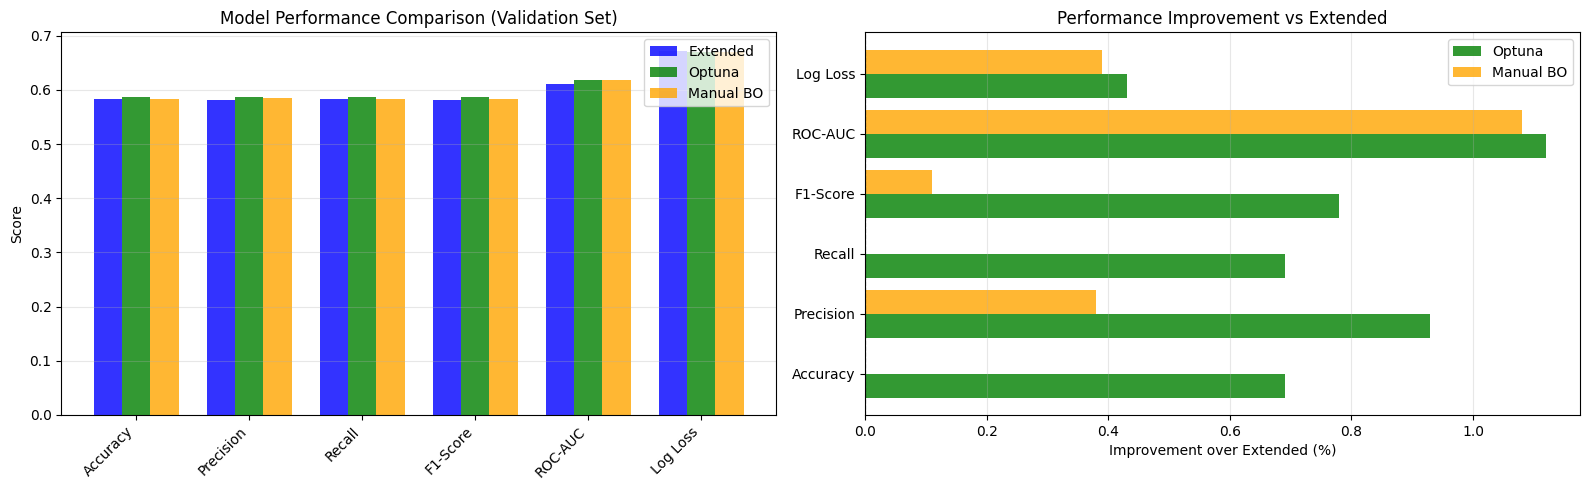

In [13]:
# Visualize comparison of all three models
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot comparison
metrics = comparison_df['Metric'].tolist()
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, comparison_df['Extended'], width, label='Extended', alpha=0.8, color='blue')
axes[0].bar(x, comparison_df['Optuna'], width, label='Optuna', alpha=0.8, color='green')
axes[0].bar(x + width, comparison_df['Manual BO'], width, label='Manual BO', alpha=0.8, color='orange')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison (Validation Set)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Improvement percentage comparison
improvement_data = pd.DataFrame({
    'Metric': metrics,
    'Optuna': comparison_df['Optuna Improvement (%)'],
    'Manual BO': comparison_df['Manual BO Improvement (%)']
})

x_pos = np.arange(len(metrics))
axes[1].barh(x_pos - 0.2, improvement_data['Optuna'], 0.4, label='Optuna', alpha=0.8, color='green')
axes[1].barh(x_pos + 0.2, improvement_data['Manual BO'], 0.4, label='Manual BO', alpha=0.8, color='orange')
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(metrics)
axes[1].set_xlabel('Improvement over Extended (%)')
axes[1].set_title('Performance Improvement vs Extended')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## #3: Feature Importance Analysis & Model Retraining

### #3.1: Calculate and Visualize Feature Importance
Analyze which features are most important for the tuned model's predictions.

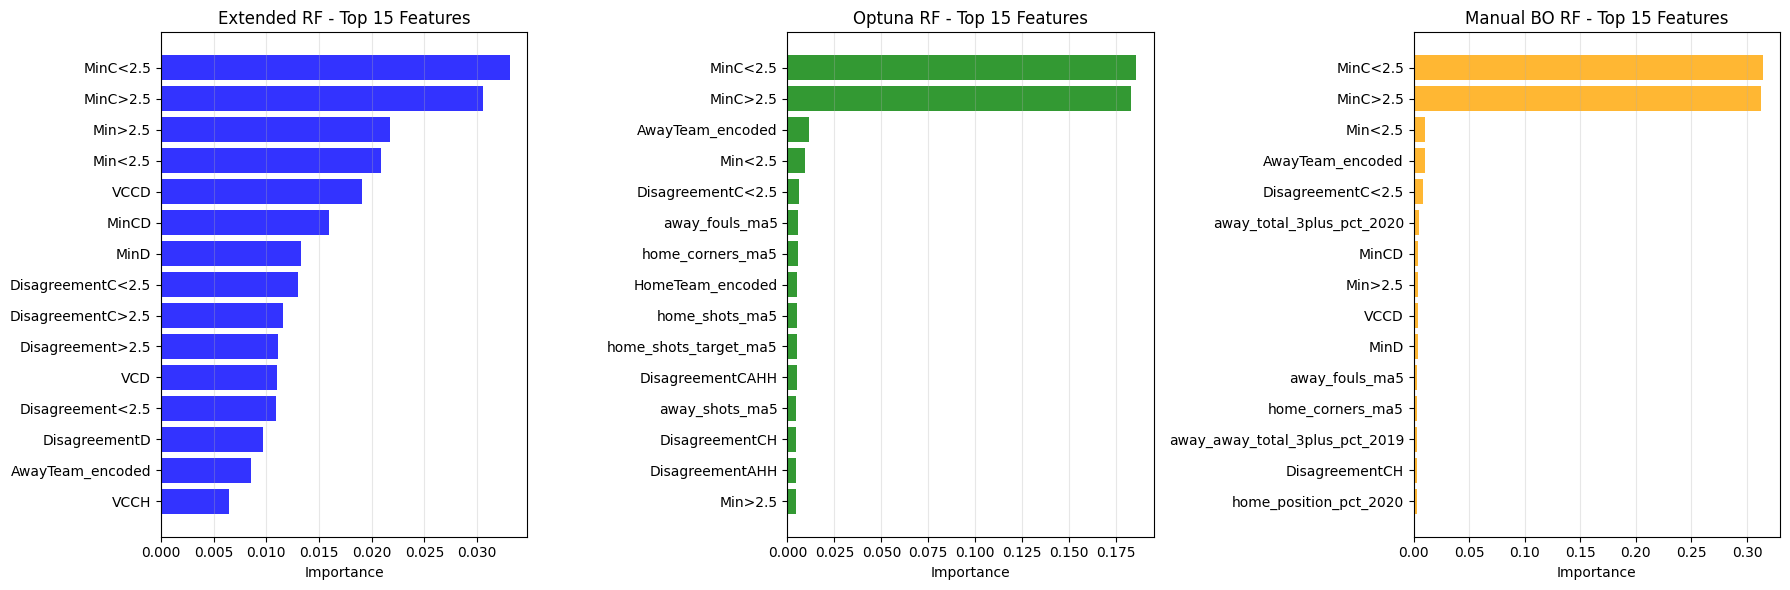


Top 10 Most Important Features (Optuna Model):
              feature  importance
             MinC<2.5    0.185599
             MinC>2.5    0.182766
     AwayTeam_encoded    0.011658
              Min<2.5    0.009605
    DisagreementC<2.5    0.006241
       away_fouls_ma5    0.005903
     home_corners_ma5    0.005728
     HomeTeam_encoded    0.005379
       home_shots_ma5    0.005266
home_shots_target_ma5    0.005028


In [14]:
# Compare feature importances across all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

top_n = 15

# Extended model
feature_importance_extended = pd.DataFrame({
    'feature': X_train.columns,
    'importance': extended_rf.feature_importances_
}).sort_values('importance', ascending=False)

axes[0].barh(range(top_n), feature_importance_extended.head(top_n)['importance'], alpha=0.8, color='blue')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(feature_importance_extended.head(top_n)['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Extended RF - Top {top_n} Features')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Optuna model
feature_importance_optuna = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_optuna.feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(range(top_n), feature_importance_optuna.head(top_n)['importance'], alpha=0.8, color='green')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(feature_importance_optuna.head(top_n)['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title(f'Optuna RF - Top {top_n} Features')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Manual BO model
feature_importance_manual = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_manual.feature_importances_
}).sort_values('importance', ascending=False)

axes[2].barh(range(top_n), feature_importance_manual.head(top_n)['importance'], alpha=0.8, color='orange')
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(feature_importance_manual.head(top_n)['feature'])
axes[2].set_xlabel('Importance')
axes[2].set_title(f'Manual BO RF - Top {top_n} Features')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print top features for best model (let's say Optuna for now, but compare both)
print("\nTop 10 Most Important Features (Optuna Model):")
print(feature_importance_optuna.head(10).to_string(index=False))

### #3.2: Feature Importance Distribution Analysis
Analyze the distribution of feature importances and cumulative importance.

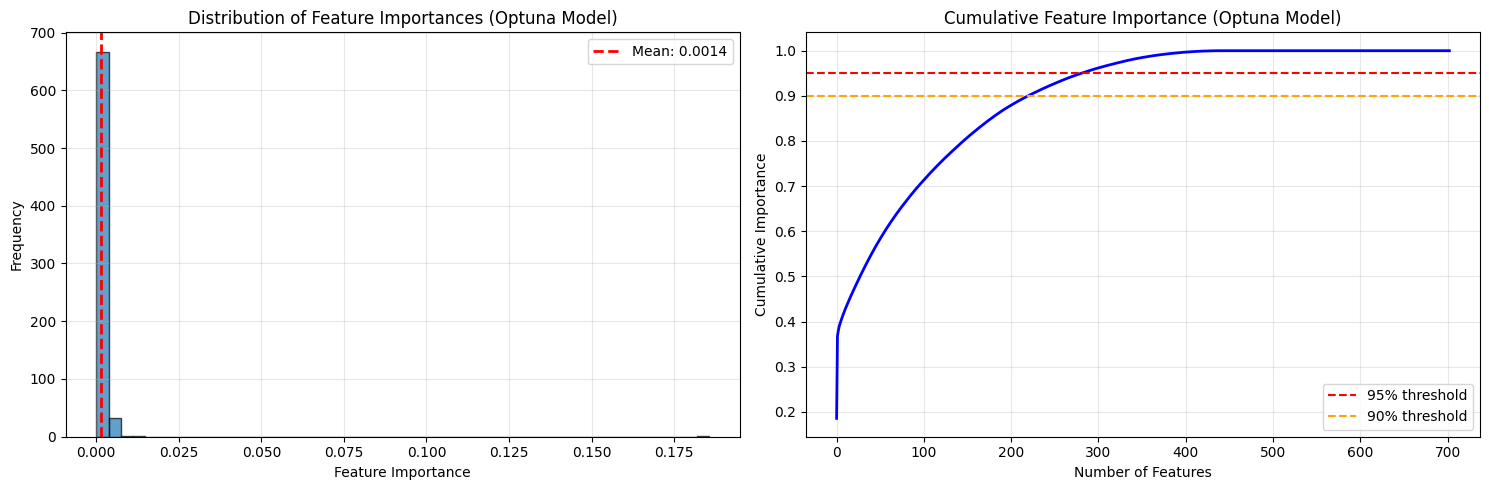


Feature Importance Summary (Optuna Model):
  Total features: 703
  Features capturing 90% importance: 221 (31.4%)
  Features capturing 95% importance: 282 (40.1%)


In [15]:
# Use Optuna model for detailed analysis (best performing)
feature_importance = feature_importance_optuna.copy()

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Importance distribution
ax1.hist(feature_importance['importance'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Feature Importance')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Feature Importances (Optuna Model)')
ax1.axvline(feature_importance['importance'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {feature_importance["importance"].mean():.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative importance
ax2.plot(range(len(feature_importance)), feature_importance['cumulative_importance'], 'b-', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')
ax2.set_title('Cumulative Feature Importance (Optuna Model)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report how many features capture 90% and 95% of importance
n_features_90 = (feature_importance['cumulative_importance'] <= 0.90).sum() + 1
n_features_95 = (feature_importance['cumulative_importance'] <= 0.95).sum() + 1

print(f"\nFeature Importance Summary (Optuna Model):")
print(f"  Total features: {len(feature_importance)}")
print(f"  Features capturing 90% importance: {n_features_90} ({n_features_90/len(feature_importance)*100:.1f}%)")
print(f"  Features capturing 95% importance: {n_features_95} ({n_features_95/len(feature_importance)*100:.1f}%)")

### #3.3: Retrain Models on Combined Train+Validation Data

Before final test set evaluation, retrain all models on the combined training and validation data (2019-2024 seasons) to maximize the amount of historical data available for predictions on the 2024/2025 test set.

**Methodological Note**: While hyperparameters were optimized using training data (2019-2023) and validated on 2023/2024 data, the final models are retrained on the combined dataset to use all available historical data before predicting the unseen 2024/2025 season. The hyperparameter values chosen in Section #2 remain fixed here—we only expand the training data to include the validation season prior to the final test set evaluation.

In [16]:
# Combine training and validation data for final model training
print("=" * 70)
print("COMBINING TRAIN + VALIDATION DATA FOR FINAL MODELS")
print("=" * 70)

X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([pd.Series(y_train), pd.Series(y_val)], axis=0)

# Reset index
X_train_full.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)

print("\nCombined Training Data:")
print(f"Features: {X_train_full.shape}")
print(f"Over 2.5 rate: {y_train_full.mean():.2%}")
print(f"Total samples: {len(y_train_full):,}")

# Cache tuned hyperparameters selected during validation-based search (Section #2)
optuna_best_params = study.best_params.copy()
manual_best_params = manual_bo_params.copy()

# Retrain extended baseline model on combined train+val data
extended_rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\n🔄 Retraining Extended Baseline Random Forest on Train+Val...")
extended_rf_final.fit(X_train_full, y_train_full)
print("✅ Extended baseline model retrained")

# Retrain Optuna model on combined train+val data with best hyperparameters from Section #2
rf_optuna_final = RandomForestClassifier(
    **optuna_best_params,
    random_state=42,
    n_jobs=-1
)

print("\n🔄 Retraining Optuna-Optimized Random Forest on Train+Val...")
rf_optuna_final.fit(X_train_full, y_train_full)
print("✅ Optuna model retrained with optimized hyperparameters")

# Retrain Manual BO model on combined train+val data with best hyperparameters from Section #2
rf_manual_final = RandomForestClassifier(
    **manual_best_params,
    random_state=42,
    n_jobs=-1
)

print("\n🔄 Retraining Manual BO Random Forest on Train+Val...")
rf_manual_final.fit(X_train_full, y_train_full)
print("✅ Manual BO model retrained with optimized hyperparameters")

print("\n" + "=" * 70)
print("ALL MODELS RETRAINED ON FULL TRAINING DATA (2019-2024)")
print("Ready for test set evaluation on 2024/2025 season")
print("=" * 70)

COMBINING TRAIN + VALIDATION DATA FOR FINAL MODELS

Combined Training Data:
Features: (35464, 703)
Over 2.5 rate: 49.85%
Total samples: 35,464

🔄 Retraining Extended Baseline Random Forest on Train+Val...

Combined Training Data:
Features: (35464, 703)
Over 2.5 rate: 49.85%
Total samples: 35,464

🔄 Retraining Extended Baseline Random Forest on Train+Val...
✅ Extended baseline model retrained

🔄 Retraining Optuna-Optimized Random Forest on Train+Val...
✅ Extended baseline model retrained

🔄 Retraining Optuna-Optimized Random Forest on Train+Val...
✅ Optuna model retrained with optimized hyperparameters

🔄 Retraining Manual BO Random Forest on Train+Val...
✅ Optuna model retrained with optimized hyperparameters

🔄 Retraining Manual BO Random Forest on Train+Val...
✅ Manual BO model retrained with optimized hyperparameters

ALL MODELS RETRAINED ON FULL TRAINING DATA (2019-2024)
Ready for test set evaluation on 2024/2025 season
✅ Manual BO model retrained with optimized hyperparameters

AL

## Data Split Methodology

**Important Note on Training/Validation/Test Split:**

The models were developed using the following data partitions:
- **Training data**: 2019-2023 seasons (used for model fitting during hyperparameter optimization)
- **Validation data**: 2023/2024 season (used for hyperparameter selection and model comparison)
- **Test data**: 2024/2025 season (held-out for final evaluation)

**Why we evaluate on the validation set during tuning:**
- Hyperparameters are selected based on validation set performance
- This prevents overfitting to any single dataset
- The test set remains completely unseen until final evaluation

**Standard practice for time-series ML:**
- Tune hyperparameters using train/validation split from historical data
- Select best model configuration based on validation performance
- Evaluate final generalization on held-out future data (test set)
- The test set (2024/2025) was never seen during optimization

## #4: Final Evaluation on Test Set

### #4.1: Evaluate All Models on Test Set
Test all three models (Extended, Optuna, Manual BO) on the held-out test set to get final performance metrics.

In [17]:
# Evaluate all models on test set (using models retrained on train+val)
print("Evaluating all models on test set...")
extended_test_results = evaluate_model(extended_rf_final, X_test, y_test, "Extended - Test Set")
optuna_test_results = evaluate_model(rf_optuna_final, X_test, y_test, "Optuna Optimized - Test Set")
manual_test_results = evaluate_model(rf_manual_final, X_test, y_test, "Manual BO Optimized - Test Set")

Evaluating all models on test set...

Performance Metrics - Extended - Test Set
Accuracy:  0.5562
Precision: 0.5581
Recall:    0.5562
F1-Score:  0.5489
ROC-AUC:   0.5943
Log Loss:  0.6802

Confusion Matrix:
[[1505 2010]
 [1154 2460]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.57      0.43      0.49      3515
    Over 2.5       0.55      0.68      0.61      3614

    accuracy                           0.56      7129
   macro avg       0.56      0.55      0.55      7129
weighted avg       0.56      0.56      0.55      7129


Performance Metrics - Optuna Optimized - Test Set
Accuracy:  0.5716
Precision: 0.5716
Recall:    0.5716
F1-Score:  0.5708
ROC-AUC:   0.6012
Log Loss:  0.6771

Confusion Matrix:
[[1856 1659]
 [1395 2219]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.57      0.53      0.55      3515
    Over 2.5       0.57      0.61      0.59      3614

    accuracy          

### #4.2: Compare All Models on Test Set
Compare extended and both optimized models' performance on the test set with comprehensive metrics.

In [18]:
# Create comprehensive test set comparison
test_comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Log Loss'],
    'Extended': [
        extended_test_results['accuracy'],
        extended_test_results['precision'],
        extended_test_results['recall'],
        extended_test_results['f1'],
        extended_test_results['roc_auc'],
        extended_test_results['log_loss']
    ],
    'Optuna': [
        optuna_test_results['accuracy'],
        optuna_test_results['precision'],
        optuna_test_results['recall'],
        optuna_test_results['f1'],
        optuna_test_results['roc_auc'],
        optuna_test_results['log_loss']
    ],
    'Manual BO': [
        manual_test_results['accuracy'],
        manual_test_results['precision'],
        manual_test_results['recall'],
        manual_test_results['f1'],
        manual_test_results['roc_auc'],
        manual_test_results['log_loss']
    ]
})

# Calculate improvement percentages
test_comparison_df['Optuna Improvement (%)'] = ((test_comparison_df['Optuna'] - test_comparison_df['Extended']) / test_comparison_df['Extended'] * 100).round(2)
test_comparison_df['Manual BO Improvement (%)'] = ((test_comparison_df['Manual BO'] - test_comparison_df['Extended']) / test_comparison_df['Extended'] * 100).round(2)

# For Log Loss, invert the improvement calculation (reduction is improvement)
log_loss_idx = test_comparison_df['Metric'] == 'Log Loss'
test_comparison_df.loc[log_loss_idx, 'Optuna Improvement (%)'] = (
    ((test_comparison_df.loc[log_loss_idx, 'Extended'].values - test_comparison_df.loc[log_loss_idx, 'Optuna'].values) /
     test_comparison_df.loc[log_loss_idx, 'Extended'].values * 100).round(2)[0]
)
test_comparison_df.loc[log_loss_idx, 'Manual BO Improvement (%)'] = (
    ((test_comparison_df.loc[log_loss_idx, 'Extended'].values - test_comparison_df.loc[log_loss_idx, 'Manual BO'].values) /
     test_comparison_df.loc[log_loss_idx, 'Extended'].values * 100).round(2)[0]
)

print("\n" + "="*80)
print("TEST SET COMPARISON: Extended vs Optuna vs Manual BO")
print("="*80)
print(test_comparison_df.to_string(index=False))
print("="*80)


TEST SET COMPARISON: Extended vs Optuna vs Manual BO
   Metric  Extended   Optuna  Manual BO  Optuna Improvement (%)  Manual BO Improvement (%)
 Accuracy  0.556179 0.571609   0.573994                    2.77                       3.20
Precision  0.558060 0.571561   0.573880                    2.42                       2.83
   Recall  0.556179 0.571609   0.573994                    2.77                       3.20
 F1-Score  0.548910 0.570799   0.573599                    3.99                       4.50
  ROC-AUC  0.594290 0.601220   0.603923                    1.17                       1.62
 Log Loss  0.680186 0.677092   0.676275                    0.46                       0.58


### #4.3: Performance Summary Across All Sets
Compare model performance across validation and test sets.


PERFORMANCE SUMMARY - VALIDATION AND TEST SETS
   Dataset     Model  Accuracy  F1-Score  ROC-AUC  Log Loss
Validation  Extended  0.582448  0.582210 0.611102  0.672574
      Test  Extended  0.556179  0.548910 0.594290  0.680186
Validation    Optuna  0.586450  0.586772 0.617952  0.669689
      Test    Optuna  0.571609  0.570799 0.601220  0.677092
Validation Manual BO  0.582448  0.582857 0.617713  0.669983
      Test Manual BO  0.573994  0.573599 0.603923  0.676275


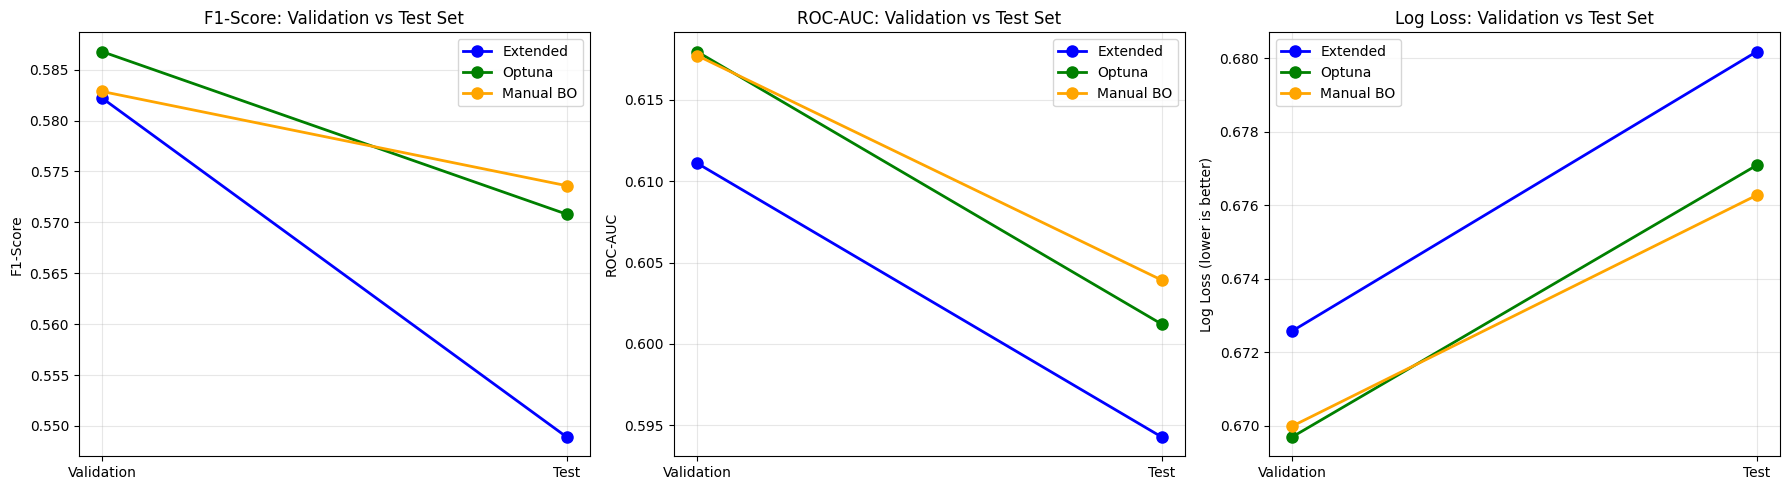

In [19]:
# Create comprehensive summary across all datasets
summary_data = {
    'Dataset': ['Validation', 'Test'] * 3,
    'Model': ['Extended'] * 2 + ['Optuna'] * 2 + ['Manual BO'] * 2,
    'Accuracy': [
        extended_val_results['accuracy'],
        extended_test_results['accuracy'],
        optuna_val_results['accuracy'],
        optuna_test_results['accuracy'],
        manual_val_results['accuracy'],
        manual_test_results['accuracy']
    ],
    'F1-Score': [
        extended_val_results['f1'],
        extended_test_results['f1'],
        optuna_val_results['f1'],
        optuna_test_results['f1'],
        manual_val_results['f1'],
        manual_test_results['f1']
    ],
    'ROC-AUC': [
        extended_val_results['roc_auc'],
        extended_test_results['roc_auc'],
        optuna_val_results['roc_auc'],
        optuna_test_results['roc_auc'],
        manual_val_results['roc_auc'],
        manual_test_results['roc_auc']
    ],
    'Log Loss': [
        extended_val_results['log_loss'],
        extended_test_results['log_loss'],
        optuna_val_results['log_loss'],
        optuna_test_results['log_loss'],
        manual_val_results['log_loss'],
        manual_test_results['log_loss']
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("PERFORMANCE SUMMARY - VALIDATION AND TEST SETS")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Plot performance across datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1-Score across datasets
datasets = ['Validation', 'Test']
extended_f1 = [extended_val_results['f1'], extended_test_results['f1']]
optuna_f1 = [optuna_val_results['f1'], optuna_test_results['f1']]
manual_f1 = [manual_val_results['f1'], manual_test_results['f1']]

axes[0].plot(datasets, extended_f1, 'o-', linewidth=2, markersize=8, label='Extended', color='blue')
axes[0].plot(datasets, optuna_f1, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[0].plot(datasets, manual_f1, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('F1-Score: Validation vs Test Set')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC-AUC across datasets
extended_auc = [extended_val_results['roc_auc'], extended_test_results['roc_auc']]
optuna_auc = [optuna_val_results['roc_auc'], optuna_test_results['roc_auc']]
manual_auc = [manual_val_results['roc_auc'], manual_test_results['roc_auc']]

axes[1].plot(datasets, extended_auc, 'o-', linewidth=2, markersize=8, label='Extended', color='blue')
axes[1].plot(datasets, optuna_auc, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[1].plot(datasets, manual_auc, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('ROC-AUC: Validation vs Test Set')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Log Loss across datasets (lower is better)
extended_logloss = [extended_val_results['log_loss'], extended_test_results['log_loss']]
optuna_logloss = [optuna_val_results['log_loss'], optuna_test_results['log_loss']]
manual_logloss = [manual_val_results['log_loss'], manual_test_results['log_loss']]

axes[2].plot(datasets, extended_logloss, 'o-', linewidth=2, markersize=8, label='Extended', color='blue')
axes[2].plot(datasets, optuna_logloss, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[2].plot(datasets, manual_logloss, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[2].set_ylabel('Log Loss (lower is better)')
axes[2].set_title('Log Loss: Validation vs Test Set')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### #4.4: Save Best Models and Results
Save the optimized models and best parameters for future use.

In [20]:
# Determine best model based on test set Log Loss (lower is better)
best_model_name = 'Optuna' if optuna_test_results['log_loss'] <= manual_test_results['log_loss'] else 'Manual BO'
best_model = rf_optuna_final if best_model_name == 'Optuna' else rf_manual_final
best_params_final = optuna_best_params if best_model_name == 'Optuna' else manual_best_params
best_test_logloss = optuna_test_results['log_loss'] if best_model_name == 'Optuna' else manual_test_results['log_loss']

print(f"\nBest Model: {best_model_name} (Test Log Loss: {best_test_logloss:.6f})")

# Save all results in a single comprehensive file
results_save_path = './outputs/models/extended_rf_results.pkl'
results_dict = {
    # Evaluation results
    'extended_val': extended_val_results,
    'extended_test': extended_test_results,
    'optuna_val': optuna_val_results,
    'optuna_test': optuna_test_results,
    'manual_val': manual_val_results,
    'manual_test': manual_test_results,

    # Models (final versions trained on train+val)
    'extended_model': extended_rf_final,
    'optuna_model': rf_optuna_final,
    'manual_bo_model': rf_manual_final,
    'best_model': best_model,
    'best_model_name': best_model_name,

    # Parameters
    'optuna_params': optuna_best_params,
    'manual_bo_params': manual_best_params,
    'best_params': best_params_final,

    # Analysis
    'feature_importance': feature_importance,
    'optuna_study': study
}
joblib.dump(results_dict, results_save_path)
print(f"\nAll models, parameters, and results saved to: {results_save_path}")
print(f"   - Extended, Optuna, and Manual BO models (trained on 2019-2024)")
print(f"   - All hyperparameters and optimization history")
print(f"   - Feature importance analysis")
print(f"   - Validation and test set results")

print("\n" + "="*80)
print(f"BEST MODEL CONFIGURATION ({best_model_name})")
print("="*80)
for key, value in best_params_final.items():
    print(f"  {key}: {value}")
print("="*80)


Best Model: Manual BO (Test Log Loss: 0.676275)

All models, parameters, and results saved to: ./outputs/models/extended_rf_results.pkl
   - Extended, Optuna, and Manual BO models (trained on 2019-2024)
   - All hyperparameters and optimization history
   - Feature importance analysis
   - Validation and test set results

BEST MODEL CONFIGURATION (Manual BO)
  n_estimators: 307
  max_depth: 5
  min_samples_split: 6
  min_samples_leaf: 6
  max_features: None
  bootstrap: True

All models, parameters, and results saved to: ./outputs/models/extended_rf_results.pkl
   - Extended, Optuna, and Manual BO models (trained on 2019-2024)
   - All hyperparameters and optimization history
   - Feature importance analysis
   - Validation and test set results

BEST MODEL CONFIGURATION (Manual BO)
  n_estimators: 307
  max_depth: 5
  min_samples_split: 6
  min_samples_leaf: 6
  max_features: None
  bootstrap: True
